# Chapter 3: Classification

This notebook covers chapter 3 of the book on the topic of classification. The prior chapter covered a regression ML project.

## Setup

Provide useful imports that will be valuable in the project.

In [11]:
import numpy as np

## MNIST

Download and play with MNIST data.

In [3]:
from sklearn.datasets import fetch_openml

# Setting `as_frame` to False to avoid the result being returned as a Pandas DataFrame (what would happen otherwise).
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Let's try to draw one of these.

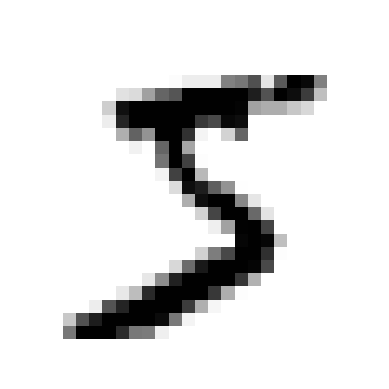

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

This shows that the number is indeed a 5 (as it looks like). However, the labels are stored as strings. Let's recast to an integer for the purpose of the ML algorithms.

In [12]:
y = y.astype(np.uint8)

Okay, now the results are (unsigned) integers.

In [13]:
y[0]

5

Let's separate data out into test and train sets.

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]